# Object Detection of Pedestrians with the Masterful CLI Trainer

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/guide_cli_object_detection_pedestrians.ipynb
[2]:https://docs.masterfulai.com/0.5.2/notebooks/guide_cli_object_detection_pedestrians.ipynb

In this guide, you will take a deeper look at Object Detection with the [Masterful CLI Trainer](../notebooks/tutorial_quickstart_cli.ipynb) to train a state of the art model. 

This guide will use the [CalTech Pedestrians](https://authors.library.caltech.edu/87172/1/05206631.pdf) dataset, which is a large video dataset of pedestrians taken from a moving vehicle as it drives around different cities.

## Define the Application

In this guide, your challenge is to build a CV model that can take an image taken from a car (aka Street Level Imagery or SLI) and identify which parts of that image contain pedestrians. Training such a model could become the heart of an Advanced Driver Assistance System: using cameras and deep learning, a model like this could alert a driver if their car is about to hit a pedestrian, or could use pedestrian information to predict a future path, or even use pedestrian information to identify potential passengers to pickup.

Since you want to identify objects in the image, and their location, the CV task for this problem is **object detection**.

## TL;DR

Don't want to read the rest of this guide, and want to start training
immediately? The following command shows you how to start training
with Masterful, using a configuration file and dataset on S3.

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/caltech_pedestrians.yaml
```

## Prepare the Data

For this guide, you will use the [Caltech Pedestrians](https://authors.library.caltech.edu/87172/1/05206631.pdf) dataset, which is an early Street Level Imagery dataset which contains richly annotated video, recorded from
a moving vehicle, with challenging images of low resolution and frequently occluded people. In this section, you will take the raw dataset and convert it into a format that Masterful can understand. Along the way, you will visualize a few examples of the data to see both the input to the model, as well as the predictions after training the model.

The original dataset can be downloaded from [here](https://drive.google.com/drive/folders/1IBlcJP8YsCaT81LwQ2YwQJac8bf1q8xF). Note this is the USA only version of this dataset, and includes SLI from US based cities only.

The dataset consists of 10 separate video sequences, in `tar` format. The video files are 640x480 30Hz comprising roughly 10 hours of total video data. By convention, the first 5 sets (`set00 - set05`) are used for training, and the other 5 sets (`set06 - set10`) are used for testing. Each set consists of multiple video sequence files (`.seq`) which can be extracted using an [opencv.VideoCapture](https://docs.opencv.org/4.x/d8/dfe/classcv_1_1VideoCapture.html) object.

Along with the video captures, the dataset includes an `annotations` folder which contains the per-frame annotations for every frame in every video. These annotations contain the bounding box information for each of the pedestrians in the videos.

As is typical with most public datasets, your first challenge is to convert the dataset from the raw dump of data into a form that is understable by an ML system. In this instance, you will convert the dataset into a set of PNG image files per frame, and a Masterful formatted label file for each image.

Converting each dataset is typically a one-off operation that is different for every dataset you want to train with. In the [Appendix](#appendix), you can follow the detailed instructions on how to convert the raw Pedestrians dataset into Masterful format for training that you will use here. For brevity, you can use the already converted dataset located at the public S3 bucket `s3://masterful-public/datasets/caltech_pedestrians_usa/`. In this bucket, you will see the following files:

```
caltech_pedestrians_usa\
  label_map.csv
  test.csv
  train_1hz.csv
  data\
```

For the above training data, the original videos were 30 frames per second. You don't need to train on all 30 frames per second however, since a lot of video data is redundant. In the above example, the `train_1hz.csv` file has selected 1 frame per second from the original video to use as the training data. This will give you a good estimate of the models performance while keeping the training time to a reasonable amount. In future guides, you will explore how to improve the performance of this model through the addition of both labeled and unlabeled data, and how to select which data to add to efficiently improve the performance of this model.

One thing to note about the converted dataset above is that you are training on every 30th frame of data, but the test (or holdout) dataset keeps every from of data, and is dramatically larger than the training dataset. Why? Understanding the performance of your model, and trying to predict the generalization performance of your model, is incredibly important. You should always strive to have the largest, most complete set of evaluation data as possible. In this case, you have almost ~70k frames of evaluation data, with only ~2k frames of training data. While this means that evaluating your trained model will take a lot longer, this is only done once at the end and will provide a comprehensive understanding of how your model is likely to perform on real production data. And while 70k frames of data might seem like alot, remember this is only coming from 5 different videos, so the overall amount of diversity in your training data is quite low.

### Explore the Data

You should always visually inspect your dataset to get a sense of what the model will see, and to roughly verify that your dataset conversion routine worked properly and you are not training with corrupted or incorrect data. This is especially important for object detection since it is very easy to generate incorrect bounding boxes during dataset conversion.

In [1]:
# Install dependencies necessary to run the following
# code.
!pip install opencv-python-headless --quiet
!pip install masterful --quiet

# Import the packages used below.
import matplotlib.pyplot as plt
import os
import requests
import tarfile
import tempfile
import tensorflow as tf
import urllib.request

# Import and activate the Masterful package.
import masterful
masterful = masterful.activate()

# Helper function to visualize bounding boxes from the dataset
# on the source image.
from masterful.data.visualize import create_annotated_image

# Helper function to display a progress when downloading
# a file using HTTP.
from masterful.utils.downloader import progress_bar_factory

# This is necessary for running inside of Colab/Jupyter,
# since the CLI trainer is run outside of the kernel
# (as a script command).
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.


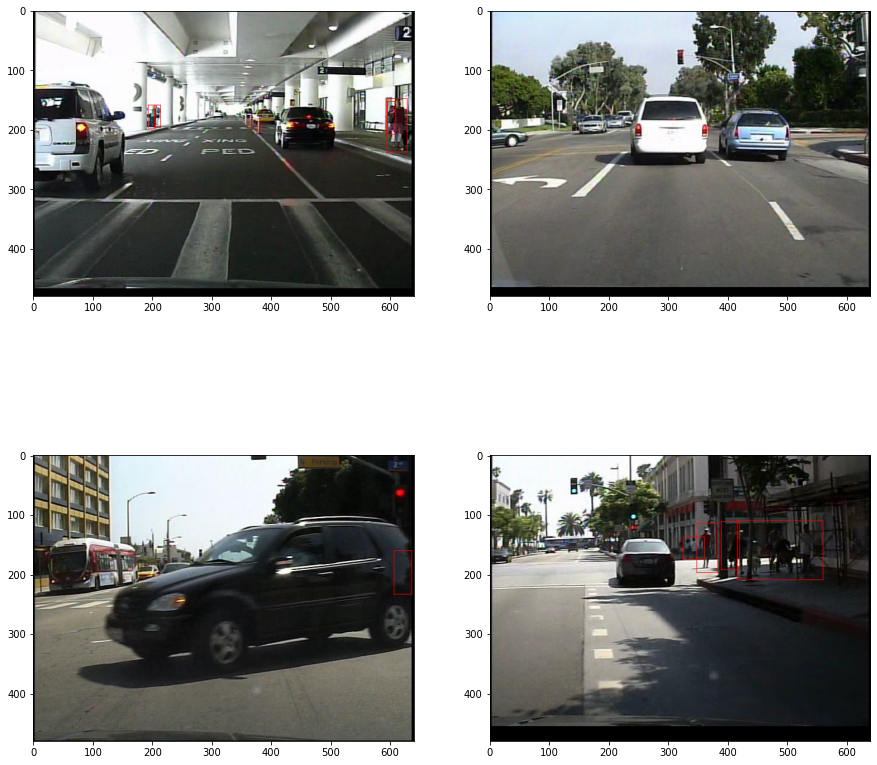

In [2]:
DATASET_ROOT = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/"
TRAINING_CSV_URL = os.path.join(DATASET_ROOT, "train_1hz.csv")

with tempfile.TemporaryDirectory() as temp_directory:
  training_csv_name = os.path.join(temp_directory, "training.csv") 
  _ =  urllib.request.urlretrieve(TRAINING_CSV_URL, training_csv_name)

  examples = []
  with open(training_csv_name) as training_csv:
    examples = training_csv.readlines()

f, axarr = plt.subplots(2, 2, figsize=(15,15))
_ = axarr[0, 0].imshow(create_annotated_image(examples[0], DATASET_ROOT))
_ = axarr[0, 1].imshow(create_annotated_image(examples[1], DATASET_ROOT))
_ = axarr[1, 0].imshow(create_annotated_image(examples[2], DATASET_ROOT))
_ = axarr[1, 1].imshow(create_annotated_image(examples[3], DATASET_ROOT))

## Configure the CLI Trainer

The Masterful CLI Trainer is a command line tool that trains a production quality model with no code required. The Masterful CLI Trainer take a [YAML](../markdown/guide_cli_yaml_config.md) configuration file as input. The configuration file fully specifies everything necessary for training, including the dataset, model, export formats, and evaluation metrics.

### Choosing a Model

Masterul provides many different state of the art object detection models that you can choose from. In general, choosing a model can have different constraints than training the model (are you deploying on server or edge? Runtime or latency constraints? Memory constraints?). You generally want to choose a model that is large enough to fit your data, but not so large as to overfit the training data and "memorize" the results, which can lead to poor generalization performance.

The Masterful Object Detection Model Zoo supports the following model architectures.

| Model Name                        | Year | Description                                                                                                                                                                                |
|-----------------------------------|------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `ssd_mobilenet_v1_fpn`            | 2018 | Single-Shot Detector with MobileNet V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                  |
| `ssd_mobilenet_v2`                | 2018 | Single-Shot Detector with MobileNet V2 backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                                  |
| `ssd_mobilenet_v2_fpnlite`        | 2018 | Single-Shot Detector with MobileNet V2 Feature Pyramid Lite backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                             |
| `ssd_resnet50_v1_fpn`             | 2018 | Single-Shot Detector with ResNet-50 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                  |
| `ssd_resnet101_v1_fpn`            | 2018 | Single-Shot Detector with ResNet-101 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                 |
| `ssd_resnet152_v1_fpn`            | 2018 | Single-Shot Detector with ResNet-152 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                 |
| `retinanet_50`                    | 2018 | RetinaNet with ResNet-50 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                             |
| `retinanet_101`                   | 2018 | RetinaNet with ResNet-101 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                            |
| `retinanet_152`                   | 2018 | RetinaNet with ResNet-152 V1 Feature Pyramid backbone, from the paper [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)                                            |
| `ssd_efficientdet_d0`             | 2019 | EfficientDet-D0 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d1`             | 2019 | EfficientDet-D1 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d2`             | 2019 | EfficientDet-D2 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d3`             | 2019 | EfficientDet-D3 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d4`             | 2019 | EfficientDet-D4 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d5`             | 2019 | EfficientDet-D5 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d6`             | 2019 | EfficientDet-D6 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `ssd_efficientdet_d7`             | 2019 | EfficientDet-D7 model from the paper [EfficientDet: Scalable and Efficient Object Detection](https://arxiv.org/abs/1911.09070)                                                             |
| `faster_rcnn_resnet50_v1`         | 2016 | Faster R-CNN model with a ResNet-50 V1 backbone, from the paper [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)         |
| `faster_rcnn_resnet101_v1`        | 2016 | Faster R-CNN model with a ResNet-101 V1 backbone, from the paper [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)        |
| `faster_rcnn_resnet152_v1`        | 2016 | Faster R-CNN model with a ResNet-152 V1 backbone, from the paper [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)        |
| `faster_rcnn_inception_resnet_v2` | 2016 | Faster R-CNN model with an Inception ResNet V2 backbone, from the paper [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497) |
| `centernet_hourglass_104`         | 2019 | CenterNet model with an Hourglass-104 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                       |
| `centernet_resnet50_v1_fpn`       | 2019 | CenterNet model with a ResNet-50 V1 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                         |
| `centernet_resnet101_v1_fpn`      | 2019 | CenterNet model with a ResNet-101 V1 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                        |
| `centernet_resnet50_v2`           | 2019 | CenterNet model with a ResNet-50 V2 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                         |
| `centernet_mobilenet_v2_fpn`      | 2019 | CenterNet model with a MobileNet V2 backbone, from the paper [Objects as Points](https://arxiv.org/abs/1904.07850)                                                                         |  


In the example below, you will select a [Faster R-CNN](https://arxiv.org/abs/1506.01497) model with a [ResNet-50](https://arxiv.org/abs/1512.03385) backbone. This model has a good trade-off between training time and quality, and is a pretty good place to start model exploring.

### The Configuration File

The following section is a condensed YAML configuration file for training against this dataset. It points to the dataset created above, and selects a `faster_rcnn_resnet50_v1` model, which is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) model with a ResNet-50 backbone.

In [3]:
MODEL_OUTPUT_DIRECTORY = tempfile.TemporaryDirectory().name
TRAINING_CONFIG = f"""
dataset:
  root_path: https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/
  splits: [train_1hz, test]
  label_map: label_map
  optimize: True

model:
  architecture: faster_rcnn_resnet50_v1
  num_classes: 2
  input_shape: [640,640,3]

training:
  task: detection
  training_split: train_1hz

output:
  formats: [saved_model]
  path: {MODEL_OUTPUT_DIRECTORY}

evaluation:
  split: test
"""

## Train the Model

Typically the YAML configuration file will exist on S3 or on your local disk. In this instance, you defined it in a local variable above, so you need to write the string into a local configuration file so that the Masterful CLI Trainer can see it.

Below, we will setup the CLI and configuration file to run in this notebook. However, if you want to train this model outside of the notebook, against the dataset on S3, you can run:

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/caltech_pedestrians.yaml
```

In [4]:
# Write the configuration file locally to disk so
# that the CLI trainer can see it.
temp_directory = tempfile.TemporaryDirectory()
yaml_path = os.path.join(temp_directory.name, "training.yaml")
with open(yaml_path, "w") as yaml:
  yaml.write(TRAINING_CONFIG)
tf.keras.backend.clear_session()

Now that you have a configuration file, you can use the Masterful CLI Trainer to train the model.

NOTE: Object detection models are quite large. Depending on your GPU, this could take several hours to complete, so plan accordingly.

In [5]:
# Use the Masterful CLI to train the model
!masterful-train --config $yaml_path

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.
MASTERFUL [22:37:19]: Training with configuration '/tmp/tmpuxs7vele/training.yaml':
----------  ------------------------------------------------------------------------------------------------
dataset     root_path  https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/
            splits     ['train_1hz', 'test']
            label_map  label_map
            optimize   True
model       architecture  faster_rcnn_resnet50_v1
            num_classes   2
            input_shape   [640, 640, 3]
training    task            detection
            training_split  train_1hz
output      formats  ['saved_model']
            path     /tmp/tmplrymi9nr
evaluation  split  test
----------  ------------------------------------------------------------------------------------------------
MASTERFUL [22:37:22]: Building model 'faster_rcnn_resnet50_v1'...
MASTERFUL [22:37:26]: Using model faste

MASTERFUL [23:18:54]: Training dataset learner finished at 23:18:54 in 3 seconds (3s), returned:
-------------------------  -----------------------------
num_classes                2
task                       Task.DETECTION
image_shape                (640, 640, 3)
image_range                ImageRange.ZERO_255
image_dtype                <dtype: 'float32'>
image_channels_last        True
label_dtype                <dtype: 'float32'>
label_shape                (22, 7)
label_structure            TensorStructure.SINGLE_TENSOR
label_sparse               False
label_bounding_box_format  BoundingBoxFormat.TENSORFLOW
-------------------------  -----------------------------
MASTERFUL [23:18:54]: Meta-learning test dataset parameters...
MASTERFUL [23:18:55]: Test dataset learner finished at 23:18:55 in 1 seconds (1s), returned:
-------------------------  -----------------------------
num_classes                2
task                       Task.DETECTION
image_shape                (640, 640, 3)


MASTERFUL [23:35:41]: Masterful will use 427 labeled examples as a validation set since no validation data was provided.
MASTERFUL [23:35:41]: Training model with:
MASTERFUL [23:35:41]: 	3845 labeled examples.
MASTERFUL [23:35:41]: 	427 validation examples.
MASTERFUL [23:35:41]: 	0 synthetic examples.
MASTERFUL [23:35:41]: 	0 unlabeled examples.
MASTERFUL [23:35:43]: Training model with learned parameters court-excited-approval in two phases.
MASTERFUL [23:35:43]: The first phase is supervised training with the learned parameters.
MASTERFUL [23:35:43]: The second phase is semi-supervised training to boost performance.
MASTERFUL [23:35:50]: Warming up model for supervised training.
MASTERFUL [23:35:57]: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL [23:49:12]: 	Warming up training for 4805 steps.
100%|████████████████████████████████████| 4805/4805 [25:18<00:00,  3.17steps/s]
MASTERFUL [00:14:31]: 	Validating batch norm statistics after warmup for stabilit

## Analyze the Results

At the end of training, Masterful will evaluate your model based on the test (sometimes called holdout) dataset you specified in the `evaluation` section of your configuration file. The evaluation results are different for each task, since every computer vision task has both general metrics (such as loss) as well as task-specific metrics (IoU for semantic segmentation for example). These results are printed to the console, as well as saved into a CSV file in the output directory specified in your configuration file.

### Object Detection Evaluation Metrics

For Object Detection, Masterful reports three main categories of metrics: Model Loss, COCO Metrics, and Confusion matrix.

#### Model Loss

The first set of metrics Masterful reports is the overall loss of the model. For object detection models, Masterful reports the total loss as well as any sub-losses that are specific to the model architecture. For example, the loss is typically composed of a localization loss (which reflects the location and size of the bounding box) and a classification loss (which reflects which object is in the box). Different models have different sub-losses, and you can gauge how your model is doing on the different tasks based on the final results of these sub-metrics.

The following is the loss results from the above training run (this might be different if you rerun the above cells):  

```
MASTERFUL [13:34:37]: ************************************
MASTERFUL [13:34:38]: Evaluating model on 64999 examples from the 'test' dataset split:
64999/64999 [==============================] - 3277s 50ms/step - loss: 0.3804 - Loss/RPNLoss/localization_loss: 0.1288 - Loss/RPNLoss/objectness_loss: 0.0497 - Loss/BoxClassifierLoss/localization_loss: 0.0720 - Loss/BoxClassifierLoss/classification_loss: 0.1299 - Loss/regularization_loss: 0.0000e+00 - Loss/total_loss: 0.3804      
MASTERFUL [14:29:15]:   Loss: 0.0647
MASTERFUL [14:29:15]:   Loss/Rpnloss/Localization Loss: 0.0000
MASTERFUL [14:29:15]:   Loss/Rpnloss/Objectness Loss: 0.0005
MASTERFUL [14:29:15]:   Loss/Boxclassifierloss/Localization Loss: 0.0144
MASTERFUL [14:29:15]:   Loss/Boxclassifierloss/Classification Loss: 0.0498
MASTERFUL [14:29:15]:   Loss/Regularization Loss: 0.0000
MASTERFUL [14:29:15]:   Loss/Total Loss: 0.0647
```

As you can see in the above output, the total loss of the model is `MASTERFUL [14:29:15]:   Loss: 0.0647` (which matches the `Loss/Total Loss` output as well). You can check the localization and classification loss as well, and you can see that the classification loss `0.0498` is slightly worse than the localization loss `0.0144`. These seem lke pretty good loss values. They are relatively low and close to zero, which is the goal of the optimizer in machine learning training. However, it's really difficult to understand intuitively what these mean in terms of your models overall performance. Are these good values? Or bad ones? Let's dive into the rest of the metrics to answer these questions.



#### COCO Metrics

[Common Objects in Context](https://cocodataset.org/#home) (COCO) is a large-scale object detection, segmentation, and captioning dataset. COCO has several features:

* Object segmentation
* Recognition in context
* Superpixel stuff segmentation
* 330K images (>200K labeled)
* 1.5 million object instances
* 80 object categories
* 91 stuff categories
* 5 captions per image
* 250,000 people with keypoints

The dataset itself is used in many research papers as a standard object detection benchmark. Importantly, COCO also defines a standard set of metrics for evaluating object detection models, commonly called the COCO (MS-COCO) Evaluation Metrics.

The following 12 metrics are used for characterizing the performance of an object detector as part of the COCO detection challenge:

![MSCOCO Metrics](../images/mscoco_metrics.png)

* Unless otherwise specified, AP and AR are averaged over multiple Intersection over Union (IoU) values. Specifically we use 10 IoU thresholds of .50:.05:.95. This is a break from tradition, where AP is computed at a single IoU of .50 (which corresponds to our metric AP<sup>IoU=.50</sup>). Averaging over IoUs rewards detectors with better localization.
* AP is averaged over all categories. Traditionally, this is called "mean average precision" (mAP). We make no distinction between AP and mAP (and likewise AR and mAR) and assume the difference is clear from context.
* AP (averaged across all 10 IoU thresholds and all 80 categories) will determine the challenge winner. This should be considered the single most important metric when considering performance on COCO.
In COCO, there are more small objects than large objects. Specifically: approximately 41% of objects are small (area < 322), 34% are medium (322 < area < 962), and 24% are large (area > 962). Area is measured as the number of pixels in the segmentation mask.
* AR is the maximum recall given a fixed number of detections per image, averaged over categories and IoUs. AR is related to the metric of the same name used in proposal evaluation but is computed on a per-category basis.
* All metrics are computed allowing for at most 100 top-scoring detections per image (across all categories).
* The evaluation metrics for detection with bounding boxes and segmentation masks are identical in all respects except for the IoU computation (which is performed over boxes or masks, respectively).

For more information about things like Average Precision and Recall and IoU in the context of Object Detection, there are several good walkthroughs below with worked examples. They will give you a better intuitive sense of what the metrics are trying to convey: 

[An Introduction to Evaluation Metrics for Object Detection](https://blog.zenggyu.com/en/post/2018-12-16/an-introduction-to-evaluation-metrics-for-object-detection/)  
[Object Detection Metrics With Worked Example](https://towardsdatascience.com/on-object-detection-metrics-with-worked-example-216f173ed31e)


Below, you will find the COCO metrics for the model you trained above:  

```
MASTERFUL [12:01:29]: Calculating MSCOCO evaluation metrics:
MSCOCO Metrics: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64999/64999 [2:13:00<00:00,  8.15it/s]
MASTERFUL [14:15:46]:   DetectionBoxes_Precision/mAP: 0.0823
MASTERFUL [14:15:46]:   DetectionBoxes_Precision/mAP@.50IOU: 0.1887
MASTERFUL [14:15:46]:   DetectionBoxes_Precision/mAP@.75IOU: 0.0580
MASTERFUL [14:15:46]:   DetectionBoxes_Precision/mAP (small): 0.0311
MASTERFUL [14:15:46]:   DetectionBoxes_Precision/mAP (medium): 0.1448
MASTERFUL [14:15:47]:   DetectionBoxes_Precision/mAP (large): 0.3358
MASTERFUL [14:15:47]:   DetectionBoxes_Recall/AR@1: 0.0805
MASTERFUL [14:15:47]:   DetectionBoxes_Recall/AR@10: 0.1607
MASTERFUL [14:15:47]:   DetectionBoxes_Recall/AR@100: 0.1636
MASTERFUL [14:15:47]:   DetectionBoxes_Recall/AR@100 (small): 0.1052
MASTERFUL [14:15:47]:   DetectionBoxes_Recall/AR@100 (medium): 0.2385
MASTERFUL [14:15:47]:   DetectionBoxes_Recall/AR@100 (large): 0.5039
MASTERFUL [14:15:47]:   DetectionBoxes_PerformanceByCategory/mAP/person: 0.1560
MASTERFUL [14:15:47]:   DetectionBoxes_PerformanceByCategory/mAP/people: 0.0087
```

The primary aggregated metric above is `DetectionBoxes_Precision/mAP`, which is the Average Precision calculated over all of the IoU thresholds. Secondarily, the `DetectionBoxes_Precision/mAP@.50IOU` corresponds to the Average Precision at just the 0.5 IoU threshold, which is a good intuitive indicator of performance and corresponds to the older Pascal VOC object detection metrics. The models scores relatively low on both of these metrics (`0.0823` and `0.1887`) respectively. As you can see in the per-category metrics (`DetectionBoxes_PerformanceByCategory`), the model scores significantly higher on the `person` class over the `people` class, which means the model is better at detecting individual people rather than groups of people. This is illuminating a defect in the training dataset. The `people` class is really just a failure of the labelers to identify individual pedestrians in the image, and is a measure of a human labelers confusion about when to group people together versus when to label them individually. Importantly, this confusion has transferred over to the model. You can see the mAP<sup>IoU=0.5</sup> metrics are 2.5x the mAP value, and the per-category metrics demonstrate this is entirely dominated by the performance on the `people` class alone. So the model performance on `people` for `IoU=0.5` is likely `~0.40`, which is a very good score. One way to verify this is to look at a few example predictions on the dataset and visually confirm the model is making good predictions.



#### Confusion Matrix

The final set of metrics Masterful provides for Object Detection is the confusion matrix of predictions versus labels. The confusion matrix helps figure out where and how the model makes mistakes.  

Below is the output for the confusion matrix from the training process:  

```
Confusion Matrix: 100%|████████████████████████████████████████████████████████████| 64999/64999 [2:05:53<00:00,  8.61it/s]
MASTERFUL [18:52:13]:   Confusion Matrix:
MASTERFUL [18:52:13]:            |  person|  people|
MASTERFUL [18:52:13]:      person| 61609.0|  2180.0|
MASTERFUL [18:52:13]:      people|  4578.0|   839.0|
MASTERFUL [18:52:13]:     Confusion matrix columns represent the prediction labels and the rows represent the real labels.
```

In the above output, the columns represent the predictions made for the model. So the `person` column represents all of the examples where the model predicted `person`. For this column, each row represents the label in the dataset. So for the `person` column, the row `person` represents all of the examples where the model predicted `person` and the label in the dataset was also `person`. These are considered the **true positives** - the examples where the model made a correct positive prediction. In the `person` column, the `people` row represents the examples where the model predicted `person`, but the true label was actually `people`. These are considered **false positives** - examples where the model correctly detected an object but predicted the wrong class. However, because a detection task requires **both** correctly identifying the presence of an object as well as correctly classify the type of that object, it is possible that the model predicts the existence of an object that does not exist. This is quantified in the `background` row of the above matrix. For example, In the `person` column, the `background` cell represents all of the examples where the model predicted a `person`, but there was no actual `person` in that location or image. These are `false postives` where the model predicted the incorrect existence of a `person`, rather than correctly predicting the existence but mis-categorizing the object instance. But if the `background` row contains predictions where there should not have been any, what does the `background` column represent? The `background` column represents predictions that were **not** made. In other words, for the `background` column and `person` row, this cell represents the examples where a `person` existed but the model failed to predict a `person` at this position. This represents a `false negative` prediction from the model.

As you can see, the diagonal of the confusion matrix represents all of the correct positive predictions of the model. The off-diagonals represent different mistakes the model made in its predictions.

In the above explanation, you have see the location of the `true positives` (the diagonals) and the location of the `false positives` (off-diagonals) and `false negatives` (`background` column). One question you might ask, is where are the `true negatives` - the examples where there were no instances of an object and the model correctly made no predictions? There are two ways to interpret `false negatives` from the above matrix. The first is as `true positives` on the `background` class - the diagonal entry in the `background` column and row. These are the instances in the dataset with no objects and the model correctly predicted no objects. In this dataset however, every example has an object. You can see this in the test dataset analysis output for the `Num Empty Images (No Labels)` row:  

```
MASTERFUL [10:13:32]: Test Dataset Analysis:
-----------------------------  ----------------------------------------
Total Examples                 100
Label Counts                   0  70
                               1  57
Label Distribution             0  0.112
                               1  0.0912
.
.
.
Num Empty Images (No Labels):  0
Total Objects                  625
```

Another way to categorize `true negatives` is that every `true positive` on one class is a corresponding `true negative` on another class - correctly predicting the existence of one class is also correctly predicting the absence of another class, or all other classes. However, neither of these definitions provide much value, and importantly they can overestimate derived metrics. For example, `accuracy` is commonly defined as the number of "correct" predictions (`true positives` plus `true negatives`) over the total number of objects. In object detection however, this will drastically over-estimate the accuracy of the model given the presence of the `true negatives` term, which when averaged over all of the classes you would most likely end up with more `true negatives` than object instances in the dataset. This is historically why object detection has relied on `precision` and `recall` metrics, rather than `accuracy`, due to the lack of a `true negative` term in the definition of the former.  

### View the Predictions

While the mAP metrics are a good quantitative indicator of the performance of your model, visualizing the predictions can help you get a qualititative sense of how well your trained model is performing. Below you can see the predictions the above trained model has on the examples you visualized above. The red boxes are the labels from the dataset, and the green boxes are the predictions made by the model.

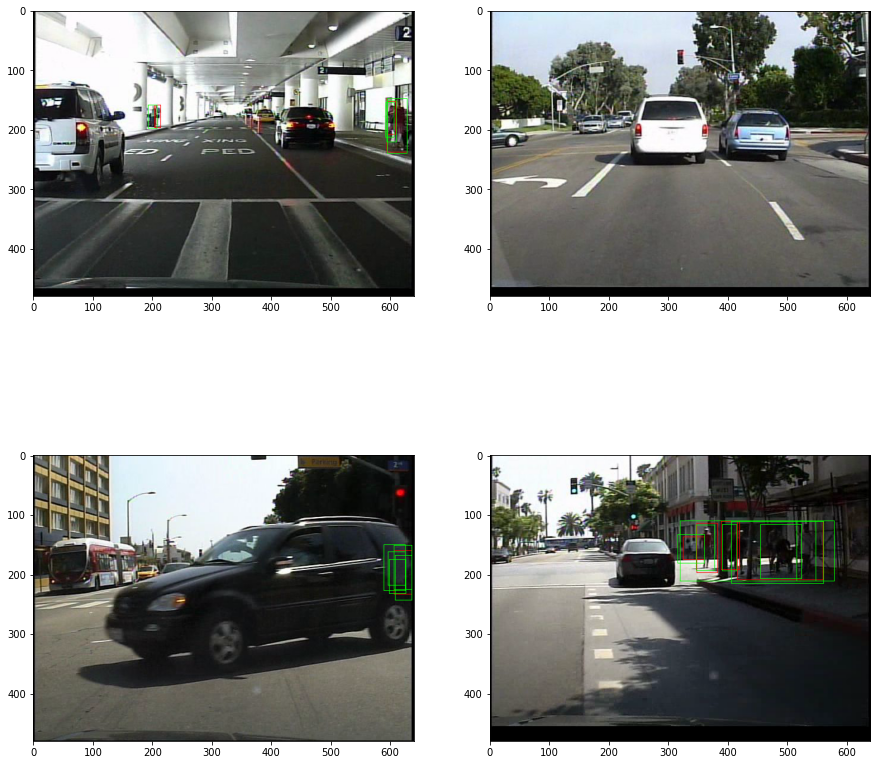

In [6]:
# Download the pretrained model so that you can
# visualize the results.
MODEL_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/caltech_pedestrians_saved_model.tar.gz"

model = None
with tempfile.TemporaryDirectory() as temp_directory:
  # Download the pretrained model from S3.
  saved_model_path = os.path.join(temp_directory, "saved_model.tar.gz") 
  _ =  urllib.request.urlretrieve(MODEL_URL, saved_model_path, progress_bar_factory("Downloading Model: "))

  # Extract the model weights from the tar file.
  with tarfile.open(saved_model_path) as tar:
    tar.extractall(temp_directory)
  saved_model_path = os.path.join(temp_directory, "saved_model") 

  # Load the trained tensorflow saved model.
  model = tf.saved_model.load(saved_model_path)
  
  # Plot a few different instances from the dataset.
  f, axarr = plt.subplots(2, 2, figsize=(15,15))
  _ = axarr[0, 0].imshow(create_annotated_image(examples[0], DATASET_ROOT, model))
  _ = axarr[0, 1].imshow(create_annotated_image(examples[1], DATASET_ROOT, model))
  _ = axarr[1, 0].imshow(create_annotated_image(examples[2], DATASET_ROOT, model))
  _ = axarr[1, 1].imshow(create_annotated_image(examples[3], DATASET_ROOT, model))

As you can see in the above examples, the model does a decent job of finding the pedestrians in the first two images. In the third image, the model misses a highly occluded pedestrian behind the white truck on the left, but this an incredibly challenging instance to detect, given the low resolution of the video and the fact that at most, maybe the head of the pedestrian is visible through the windshield of the truck. Likewise, in the fourth image, the model misses the group of people that are highly occluded behind the cars on the left. Another challenging miss given the people are barely visible. So even though the overall mAP of the model `0.0823` and the mAP<sup>IoU=0.5</sup> `0.1887` is relatively low, it looks like our first attempt at training the model has done a pretty good job at detecting pedestrians in low resolution video images!

## Using the Model for Inference

The [Output Formats](../markdown/guide_cli_model_output_formats.md) guide has more information about how to use the models output by Masterful. Object Detection has a few other intricacies that should be addressed though, since the model outputs both a location of an object, a class instance for that object, and a measure of the confidence in the prediction. First, the below code shows how to make a prediction using the model we loaded above on the examples you visualized in the [View the Predictions](#view-the-predictions) section:

In [8]:
# This image corresponds to the first image (upper left)
# in the `View the Predictions` section above.
IMAGE_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/data/images/set00_V007_1770.png"

# Download the image to use for generating a prediction
# and convert it into a tensor.
http_response = requests.get(IMAGE_URL, stream=True)
image = tf.io.decode_image(http_response.raw.read())

image_height = image.shape[0]
image_width = image.shape[1]
print(f"Image Shape: height={image_height} width={image_width}.")

# The default inference function for tensorflow saved
# models is named `serving_default`.
inference_fn = model.signatures["serving_default"]

# The inference function is a one-arg callable, whose
# input argument is `image` - the image to predict on,
# and which returns a dictionary of outputs. The dictionary
# contains an item whose key is `prediction`, which is the
# predictions of the model.
predictions = inference_fn(image=image)['prediction']

# Convert the predictions to NumPY for easier processing.
predictions = predictions.numpy()

# The predictions from an object detection model
# have the shape [batch size, number of boxes, 6]. 
# The batch size will always be 1 for inference models,
# since they expect only one image for to predict on.
# The number of boxes predicted depends on the model
# configuration and represents the maximum number of boxes
# predicted for each example. A typical value is 100.
print(f"Predictions shape is {predictions.shape}")
print(f"Maximum number of boxes predicted is {predictions.shape[1]}")

# The final dimension of the prediction represents the boxes,
# classes, and confidences predicted by the model. This dimension
# is of form: [ymin, xmin, ymax, xmax, class id, confidence].
# The box values are normalized against the image size, and are
# in the range [0,1].
#
# The confidence score is a value in the range [0,1] which represents 
# the confidence of the prediction, similar to the confidence
# of a classification model represented by the softmax probabities
# of the class predictions. The step to determingin the `true`
# predictions is to threshold the predictions by the confidence
# score. A typical scheme is to use only the predictions whose
# confidence is greater than 0.5 as the threshold, but you can
# experiment with different threshold values for your use case.
threshold = 0.5
true_predictions = predictions[predictions[:, :, 5] > threshold]
print(f"Found {true_predictions.shape[1]} confident predictions out of {predictions.shape[1]} total predictions.")

# Print the model predictions above the given threshold
label_map = {0: 'person', 1: 'people'}
for i in range(true_predictions.shape[0]):
  print(f"Prediction {i}:")
  print(f"  Class:  {label_map[true_predictions[i][4]]}")
  print(f"  Left:   {int(true_predictions[i][1]*image_width)}")
  print(f"  Top:    {int(true_predictions[i][0]*image_height)}")
  print(f"  Right:  {int(true_predictions[i][3]*image_width)}")
  print(f"  Bottom: {int(true_predictions[i][2]*image_height)}")

Image Shape: height=480 width=640.
Predictions shape is (1, 300, 6)
Maximum number of boxes predicted is 300
Found 6 confident predictions out of 300 total predictions.
Prediction 0:
  Class:  person
  Left:   596
  Top:    148
  Right:  629
  Bottom: 240
Prediction 1:
  Class:  person
  Left:   193
  Top:    159
  Right:  209
  Bottom: 198
Prediction 2:
  Class:  person
  Left:   593
  Top:    155
  Right:  607
  Bottom: 214
Prediction 3:
  Class:  person
  Left:   595
  Top:    153
  Right:  611
  Bottom: 222


You can compare the values for the raw predictions above with the visual results from the first image in the [View the Predictions](#view-the-predictions) section above, and see that there are two predictions corresponding to the two green boxes annotated above.

## Next Steps

In the above sections, you have learned how to train the model using the Masterful CLI, evaluate the performance of the model, and use the model to make predictions on your production data.

In the next series of guides, you will learn how to improve the performance of this model without labeling any additional data - using the power of Semi-Supervised Learning inside of Masterful. This is a powerful technique to maximize your production models without increasing your labeling budget or waiting for additional data to come back from your labeling service.

## Appendix

In this section you will learn how to convert the videos provided by Caltech into the representations we used above. Converting datasets is different for every dataset and use case, so you will not be able to use this code anywhere else. But the steps for each dataset are similar, so you will get a sense for the ovrall process and hopefully this will make it easier to convert your own datasets.

### Extracting the Images from the Video

The video files in the Caltech dataset are stored as raw video sequences, which can be opened using the OpenCV library. In this section, you will extract the raw images from each video into separate PNG files.

In [2]:
# Install dependencies necessary to run the following
# code.
!pip install progressbar2 --quiet

import cv2
import glob
import os
import tarfile
import tempfile
import urllib.request

# These are mirrors of the original data which is located
# in google drive at:
# https://drive.google.com/drive/folders/1IBlcJP8YsCaT81LwQ2YwQJac8bf1q8xF
SET_URLS = [
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set00.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set01.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set02.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set03.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set04.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set05.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set06.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set07.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set08.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set09.tar",
  "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/set10.tar",
]
SETS = { set_url: f"set{i:02}" for i, set_url in enumerate(SET_URLS) }

# Download the tar files to a local directory so that
# you can extract and process them.
data_directory = tempfile.TemporaryDirectory()

# The video sequence data will live under
# <data_directory>/video_sequences
sequence_directory = os.path.join(data_directory.name, "video_sequences")
os.makedirs(sequence_directory, exist_ok=True)

for url in SETS:
  tar_file = os.path.join(data_directory.name, f"{SETS[url]}.tar")
  _ = urllib.request.urlretrieve(url, tar_file, progress_bar_factory(f"Downloading {SETS[url]}: "))
  
  # Extract the downloaded tar file
  with tarfile.open(tar_file) as tar:
    tar.extractall(sequence_directory)

# Write all of the images to an 'images' directory.
images_directory = os.path.join(data_directory.name, "images")
os.makedirs(images_directory, exist_ok=True)

# Use OpenCV to save each image as a PNG. 
def save_image(set, sequence, sequence_idx, sequence_frame):
  image_name = '{}/{}_{}_{}.png'.format(
    images_directory, 
    os.path.basename(set),
    os.path.basename(sequence).split('.')[0], 
    sequence_idx)    
  cv2.imwrite(image_name, sequence_frame)

# Extract all of the images from the video sequences
total_images = 0
for set_name in sorted(glob.glob(os.path.join(sequence_directory, "set*"))):
  for sequence_name in sorted(glob.glob('{}/*.seq'.format(set_name))):
    video_capture = cv2.VideoCapture(sequence_name)
    i = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        save_image(set_name, sequence_name, i, frame)
        i += 1
    total_images += i
    print(f"Extracted: {sequence_name}")
print(f"Wrote {total_images} total images.")

set00100% (1154611200 of 1154611200) |###| Elapsed Time: 0:03:18 Time:  0:03:18
set01100% (531722240 of 531722240) |#####| Elapsed Time: 0:01:39 Time:  0:01:39
set02100% (1090877440 of 1090877440) |###| Elapsed Time: 0:03:18 Time:  0:03:18
set03100% (1211873280 of 1211873280) |###| Elapsed Time: 0:03:32 Time:  0:03:32
set04100% (1036124160 of 1036124160) |###| Elapsed Time: 0:03:12 Time:  0:03:12
set05100% (1208064000 of 1208064000) |###| Elapsed Time: 0:03:32 Time:  0:03:32
set06100% (1561139200 of 1561139200) |###| Elapsed Time: 0:04:19 Time:  0:04:19
set07100% (1000857600 of 1000857600) |###| Elapsed Time: 0:03:17 Time:  0:03:17
set08100% (946391040 of 946391040) |#####| Elapsed Time: 0:02:34 Time:  0:02:34
set09100% (1090088960 of 1090088960) |###| Elapsed Time: 0:02:55 Time:  0:02:55
set10100% (1099048960 of 1099048960) |###| Elapsed Time: 0:03:18 Time:  0:03:18
Extracted: /tmp/tmpkhsbed83/video_sequences/set00/V000.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set00/V001.seq
Ex

Extracted: /tmp/tmpkhsbed83/video_sequences/set09/V011.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V000.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V001.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V002.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V003.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V004.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V005.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V006.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V007.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V008.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V009.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V010.seq
Extracted: /tmp/tmpkhsbed83/video_sequences/set10/V011.seq
Wrote 249884 total images.


### The Masterful Label Format for Detection

Object detection labels consist of four integer points for the bounding box and a single 0-indexed integer class identifier similar to multi-class classification. The bounding boxes are specified in pixel coordinates relative to the image size, and are specified in [xmin, ymin, xmax, ymax] format, separated by commas. A single label consists of [xmin, ymin, xmax, ymax, class_id], all separated by commas, with multiple instances possible for each image. For example, here is a snippet of an object detection CSV file:  

```
images/image1.jpg,25,156,47,180,0,314,125,328,139,6
images/image2.jpg,104,180,118,194,6
images/image3.jpg,258,161,280,183,0,174,111,196,133,9,28,59,50,81,3
``` 

In the above example, the image `image1.jpg` has two objects in the image, one of class `0` and one of class `6`. Class `0` is defined by the bounding box coordinates with the upper left equal to pixel `(25,156)` and the lower right equal to pixel `(47,180)`, which corresponds to a bounding box of `width=22` and `height=24`. The object of class `6` is at coordinates upper left `(314,125)` and lower right `(328,139)`, which corresponds to a bounding box of `width=14` and `height=14`. The second image `image2.jpg` has a single instance of object class `6` in it, and the third image `image3.jpg` has 3 objects in it, of classes `0`, `9`, and `3`.  

More information about Masterful label formats can be found [here](../markdown/guide_cli_data_directory_format.md).

### Convert the Annotations to Masterful Labels

The following code converts the `annotations.zip` file from the Caltech Pedestrians dataset into a Masterful formatted training and test CSV file, which can be used with the Masterful CLI. The raw annotations files are binary Matlib files, and it takes quite a of internet sleuthingto understand the format and parse them correctly.

In [7]:
!pip install scipy --quiet
import os
import glob
from scipy.io import loadmat
from collections import defaultdict

ANNOTATIONS_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/caltech_pedestrians_usa/mirror/annotations.zip"

# Download the annotations locally
zip_file = os.path.join(data_directory.name, f"annotations.zip")
_ = urllib.request.urlretrieve(ANNOTATIONS_URL, zip_file, progress_bar_factory("Annotations: "))

import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_file:
  zip_file.extractall(data_directory.name)
annotations_directory = os.path.join(data_directory.name, "annotations")

# Parse all of the video bounding box (vbb) information
# in every VBB file for every video set.
all_objects = 0
data = defaultdict(dict)

# The annotations directory consists setXX directories
# for each video set.
for directory_name in sorted(glob.glob(os.path.join(annotations_directory, 'set*'))):
  set_name = os.path.basename(directory_name)
  data[set_name] = defaultdict(dict)
  for annotation_file_name in sorted(glob.glob('{}/*.vbb'.format(directory_name))):
    # Each VBB file is a binary MATLIB annotation file.
    vbb = loadmat(annotation_file_name)
    frame_number = int(vbb['A'][0][0][0][0][0])
    object_lists = vbb['A'][0][0][1][0]
    max_objects = int(vbb['A'][0][0][2][0][0])
    object_starting_point = vbb['A'][0][0][3][0]
    object_label = [str(v[0]) for v in vbb['A'][0][0][4][0]]
    object_str = vbb['A'][0][0][5][0]
    object_end_point = vbb['A'][0][0][6][0]
    object_hidden = vbb['A'][0][0][7][0]
    altered = int(vbb['A'][0][0][8][0][0])
    log = vbb['A'][0][0][9][0]
    log_length = int(vbb['A'][0][0][10][0][0])

    video_name = os.path.splitext(os.path.basename(annotation_file_name))[0]
    data[set_name][video_name]['frame_number'] = frame_number
    data[set_name][video_name]['max_objects'] = max_objects
    data[set_name][video_name]['log'] = log.tolist()
    data[set_name][video_name]['log_length'] = log_length
    data[set_name][video_name]['altered'] = altered
    data[set_name][video_name]['frames'] = defaultdict(list)

    num_objects = 0
    for frame_id, obj in enumerate(object_lists):
      if len(obj) > 0:
        for id, pos, occl, lock, posv in zip(obj['id'][0], obj['pos'][0],
                                             obj['occl'][0], obj['lock'][0],
                                             obj['posv'][0]):
          keys = obj.dtype.names
          id = int(id[0][0]) - 1  # MATLAB is 1-origin
          pos = pos[0].tolist()
          occl = int(occl[0][0])
          lock = int(lock[0][0])
          posv = posv[0].tolist()

          datum = dict(zip(keys, [id, pos, occl, lock, posv]))
          datum['lbl'] = str(object_label[datum['id']])
          datum['str'] = int(object_str[datum['id']])
          datum['end'] = int(object_end_point[datum['id']])
          datum['hide'] = int(object_hidden[datum['id']])
          datum['init'] = int(object_starting_point[datum['id']])
          data[set_name][video_name]['frames'][frame_id].append(datum)
          num_objects += 1
      else:
        # This frame is labeled but has no objects in it.
        data[set_name][video_name]['frames'][frame_id].append(None)

    print(directory_name, annotation_file_name, num_objects)
    all_objects += num_objects

print('Number of objects:', all_objects)

# Treat the three different `person` labels as the
# same class. `person?` and `person-fa` represent
# much harder instances to classify.
label_to_class = {
    "person": 0,
    "person?": 0,
    "person-fa": 0,
    "people": 1,
}

# From the original paper, sets 06-10 are used for testing,
# the rest are for training.
train_sets = {f"set{i:02}" for i in range(6)}
test_sets = {f"set{i:02}" for i in range(6, 11, 1)}

# Select every 30 frames (1 frame per second) in the
# train dataset.
every_n_frames = 30

# Convert the raw parsed data into individual CSV files.
# The images exist in the relative path "images".
root = "images"
train_rows = []
test_rows = []
for set_name in data.keys():
  for video_name in data[set_name].keys():
    for frame_id in data[set_name][video_name]['frames'].keys():
      row = f"{root}/{set_name}_{video_name}_{frame_id}.png"
      for object in data[set_name][video_name]['frames'][frame_id]:
        if object is not None:
          row += f",{object['pos'][0]},{object['pos'][1]},{object['pos'][0]+object['pos'][2]},{object['pos'][1]+object['pos'][3]},{label_to_class[object['lbl']]}"
      row += "\n"

      if set_name in train_sets:
        if (frame_id % every_n_frames) == 0:
          train_rows.append(row)
      elif set_name in test_sets:
        test_rows.append(row)
      else:
        raise ValueError(f"Unknown set name {set_name}")

# Shuffle the training set
import random

random.shuffle(train_rows)

# Write out the files
training_csv_path = os.path.join(data_directory.name, "train_1hz.csv")
with open(training_csv_path, "w") as csv:
  for row in train_rows:
    csv.write(row)
test_csv_path = os.path.join(data_directory.name, "test.csv") 
with open(test_csv_path, "w") as csv:
  for row in test_rows:
    csv.write(row)
print(f"Dataset root path: {data_directory.name}")
print(f"Training CSV path: {training_csv_path}")
print(f"Test CSV path: {test_csv_path}")
print(f"Images directory: {images_directory}")

Annotations: 100% (13664674 of 13664674) || Elapsed Time: 0:00:03 Time:  0:00:03
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V000.vbb 4519
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V001.vbb 7303
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V002.vbb 2334
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V003.vbb 642
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V004.vbb 1879
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V005.vbb 97
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V006.vbb 7203
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V007.vbb 10449
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V008.vbb 4978
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V009.vbb 6472
/tmp/tmpkhsbed83/annotations/set00 /tmp/tmpkhsbed83/annotations/set00/V010.vbb 70

/tmp/tmpkhsbed83/annotations/set07 /tmp/tmpkhsbed83/annotations/set07/V011.vbb 7213
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V000.vbb 2380
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V001.vbb 2887
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V002.vbb 1172
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V003.vbb 59
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V004.vbb 350
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V005.vbb 570
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V006.vbb 1695
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V007.vbb 329
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V008.vbb 992
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V009.vbb 2753
/tmp/tmpkhsbed83/annotations/set08 /tmp/tmpkhsbed83/annotations/set08/V010.vbb 245